# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
import numpy as np

from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [7]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### Start Here! Main Implementation

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


In [2]:
# Imports
import random
import os
import numpy as np
from collections import deque, namedtuple
import time
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

# Hide Matplotlib deprecate warnings
import warnings
warnings.filterwarnings("ignore")

# High resolution plot outputs for retina display
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from unityagents import UnityEnvironment

# Load a single agent of the environment
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Reset the environment    
env_info = env.reset(train_mode=True)[brain_name]     

# number of agents
num_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size

# size of the state space 
states = env_info.vector_observations  # Array of states for all agents in teh enviroonments
state_size = states.shape[1]

print('There are {} agents. Each observes a state with length: {} and act within an action space of length: {}'.format(states.shape[0], 
                                                                                                                       state_size, 
                                                                                                                       action_size))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


There are 2 agents. Each observes a state with length: 24 and act within an action space of length: 2


In [5]:
#taken from the continuous controls exercise

'''Define Utility functions:

OUNoise (Ornstein–Uhlenbeck): https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process
ReplayBuffer: storing experiences
'''

class OUNoise:
    '''OUNoise (Ornstein–Uhlenbeck): https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process'''

    def __init__(self, size, seed, mu = 0.0, theta = 0.15, sigma = 0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size) #try the standard normal this time
        #dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [6]:
#testing noise
test_noise = OUNoise(seed = 10, size = 10)
print(test_noise.state)
test_noise.sample()
print(test_noise.state)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.106 -0.498  0.294 -0.138  0.087  0.22  -0.326  0.195  0.135 -0.141]


In [7]:
class ReplayBuffer:
    # ReplayBuffer: storing experiences
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen = buffer_size)  # internal memory (deque)
        self.batch_size = batch_size #maximum size of buffer
        self.experience = namedtuple("Experience", field_names = ["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        # add to memory
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        #randomly select # of experiences from memory, where the size = batch_size
        experiences = random.sample(self.memory, k = self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        #Return the current size of internal memory
        return len(self.memory)

In [8]:
#testing replaybuffer
test_RB = ReplayBuffer(action_size = 4, buffer_size = 10, batch_size = 10, seed = 10)
for i in range(20):
    test_RB.add(state = random.choice([1, 2, 3, 4, 5]), 
                action = random.choice([1, 2, 3, 4]), 
                reward = random.choice([-1, 0, 1]), 
                next_state = random.choice([1, 2, 3, 4, 5]), 
                done = random.choice([True, False]))

print(test_RB.memory, test_RB.batch_size, '\n')
print(test_RB.sample(), '\n')

deque([Experience(state=5, action=2, reward=-1, next_state=4, done=True), Experience(state=1, action=1, reward=0, next_state=3, done=True), Experience(state=5, action=1, reward=-1, next_state=4, done=False), Experience(state=5, action=2, reward=-1, next_state=1, done=False), Experience(state=2, action=2, reward=0, next_state=4, done=False), Experience(state=4, action=2, reward=1, next_state=3, done=True), Experience(state=5, action=2, reward=-1, next_state=3, done=False), Experience(state=3, action=2, reward=1, next_state=2, done=True), Experience(state=4, action=3, reward=0, next_state=4, done=True), Experience(state=1, action=1, reward=0, next_state=3, done=True)], maxlen=10) 10 

(tensor([[ 1.],
        [ 2.],
        [ 3.],
        [ 5.],
        [ 4.],
        [ 1.],
        [ 5.],
        [ 4.],
        [ 5.],
        [ 5.]]), tensor([[ 1.],
        [ 2.],
        [ 2.],
        [ 2.],
        [ 3.],
        [ 1.],
        [ 2.],
        [ 2.],
        [ 2.],
        [ 1.]]), ten

In [10]:
#Define the agent

class Agent():
    def __init__(self, state_size, action_size, num_agents, random_seed = 0,
                actor_fc1_units = 256, actor_fc2_units = 128,
                critic_fcs1_units = 256, critic_fc2_units = 128,
                buffer_size = int(1e6), batch_size = 128,
                gamma = 0.99, tau = 8e-3 , 
                lr_actor = 1e-3, lr_critic = 1e-3, weight_decay = 0,
                add_ounoise = True, mu = 0., theta = 0.15, sigma = 0.2, 
                learn_every = 1, learn_num = 5, eps_start = 5.0, eps_ep_end = 300, eps_final = 0):
        
        # Initialize an Agent object. Note that all of there are parameters that can be potentially tuned:
        self.state_size = state_size # dimension of each state
        self.action_size = action_size # dimension of each action
        self.num_agents = num_agents
        self.random_seed = random_seed # random seed
        self.actor_fc1_units = actor_fc1_units # number of units for the layer 1 in the actor model
        self.actor_fc2_units = actor_fc2_units # number of units for the layer 2 in the actor model
        self.critic_fcs1_units = critic_fcs1_units # number of units for the layer 1 in the critic model
        self.critic_fc2_units = critic_fc2_units # number of units for the layer 2 in the critic model
        self.buffer_size = buffer_size # replay buffer size, setting up ReplayBuffer
        self.batch_size = batch_size # minibatch size, taken from ReplayBuffer
        self.gamma = gamma # discount factor
        self.tau = tau # for soft update of target parameter
        self.lr_actor = lr_actor # learning rate of the actor 
        self.lr_critic = lr_critic # learning rate of the critic 
        self.weight_decay = weight_decay # L2 weight decay  
        self.add_ounoise = add_ounoise # Ornstein-Uhlenbeck noise parameter (turn on)
        self.mu = mu # Ornstein-Uhlenbeck noise parameter
        self.theta = theta # Ornstein-Uhlenbeck noise parameter
        self.sigma = sigma # Ornstein-Uhlenbeck noise parameter

        print("Hyperparam Setting: state_size: ({}) action_size: ({}) num_agents: ({}) random_seed: ({}) actor_fc1_units: ({}) actor_fc2_units: ({}) critic_fcs1_units: ({}) critic_fc2_units: ({}) buffer_size: ({}) batch_size: ({}) gamma: ({}) tau: ({}) lr_actor: ({}) lr_critic: ({}) weight_decay: ({}) add_ounoise: ({}) mu: ({}) theta: ({}) sigma: ({}) \n".format(state_size, action_size, num_agents, random_seed, 
                                                          actor_fc1_units, actor_fc2_units, critic_fcs1_units, critic_fc2_units,
                                                          buffer_size, batch_size, gamma, tau, 
                                                          lr_actor, lr_critic, weight_decay, 
                                                          add_ounoise, mu, theta, sigma))
        
        self.eps = eps_start
        self.eps_decay = 1 / (eps_ep_end * learn_num)  # set decay rate based on epsilon end target
        self.timestep = 0

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(self.state_size, self.action_size, self.random_seed).to(device)
        self.actor_target = Actor(self.state_size, self.action_size, self.random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr = self.lr_actor)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(self.state_size, self.action_size, self.random_seed).to(device)
        self.critic_target = Critic(self.state_size, self.action_size, self.random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr = lr_critic, weight_decay = self.weight_decay)

        # Noise process
        self.noise = OUNoise(size = self.action_size, seed = self.random_seed, mu = self.mu, theta = self.theta, sigma = self.sigma)

        # Replay memory
        self.memory = ReplayBuffer(self.action_size, self.buffer_size, self.batch_size, self.random_seed)

    def step(self, state, action, reward, next_state, done, agent_number):
        # Save experience / reward
        self.timestep += 1
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
        # Learn, if enough samples are available in memory and at learning interval settings
        if len(self.memory) > batch_size and self.timestep % learn_every == 0:
                for _ in range(learn_num):
                    experiences = self.memory.sample()
                    self.learn(experiences, gamma, agent_number)

    def act(self, states):
        # using the current policy from actor_local, get an action based on the state
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.num_agents, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            # get action for each agent and concatenate them
            for agent_num, state in enumerate(states):
                action = self.actor_local(state).cpu().data.numpy()
                actions[agent_num, :] = action
        self.actor_local.train()
        # add noise to actions
        if self.add_ounoise:
            actions += self.eps * self.noise.sample()
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, agent_number):
        '''Update policy and value parameters using given batch of experience tuples. Pseudo code:
        Q_targets = reward + gamma * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        '''
        states, actions, rewards, next_states, dones = experiences

        # update critic 
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        # Construct next actions vector relative to the agent
        if agent_number == 0:
            actions_next = torch.cat((actions_next, actions[:,2:]), dim=1)
        else:
            actions_next = torch.cat((actions[:,:2], actions_next), dim=1)
        # Compute Q targets for current states (y_i)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # update actor
        # Compute actor loss
        actions_pred = self.actor_local(states)
        # Construct action prediction vector relative to each agent
        if agent_number == 0:
            actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
        else:
            actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)
        # Compute actor loss
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        #update target networks
        self.soft_update(self.critic_local, self.critic_target, tau)
        self.soft_update(self.actor_local, self.actor_target, tau)

        # update noise decay parameter
        self.eps -= self.eps_decay
        self.eps = max(self.eps, eps_final)
        self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        # Soft update model parameters. Pseudo code:
        # weight_target = tau *weight_local + (1 - tau) * weight_target
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            # updating the target params
            target_param.data.copy_(tau * local_param.data + (1.0  -tau) * target_param.data)



In [11]:
#Define the Actor and Critic Models
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    #Actor (Policy)

    def __init__(self, state_size, action_size, seed, fc1_units = 256, fc2_units = 128):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # Dense layers
        self.fc1 = nn.Linear(state_size * 2, fc1_units) #layer 1 is linear, with state_size * 2 inputs
        self.fc2 = nn.Linear(fc1_units, fc2_units) #layer 2 is linear
        self.fc3 = nn.Linear(fc2_units, action_size) #layer 3 is linear, with action size as outputs
        
        # Normalization layers (we can try normalization to see if this changes anything)
        #self.bn1 = nn.BatchNorm1d(fc1_units) #after Layer 2, there is normalization
        
        self.reset_parameters() #be sure to reset the weight at the end of initialization

    def reset_parameters(self):
        #weight reset
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        #finally taking step forward
        
        # Reshape the state to comply with Batch Normalization
        '''if state.dim() == 1:
            state = torch.unsqueeze(state, 0)'''
            
        x = F.relu(self.fc1(state))
        #x = self.bn1(x) 
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x)) #note that we are returning a tanh


class Critic(nn.Module):
    #Critic (Value), will only make comments on how this is different from Actor

    def __init__(self, state_size, action_size, seed, fcs1_units = 256, fc2_units = 128):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # Dense layers
        self.fcs1 = nn.Linear(state_size * 2, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+(action_size*2), fc2_units) #in Layer 2, we have added action_size * 2 to it's input
        self.fc3 = nn.Linear(fc2_units, 1)
        
        # Normalization layers
        #self.bn1 = nn.BatchNorm1d(fcs1_units)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        '''if state.dim() == 1:
            state = torch.unsqueeze(state, 0)'''
        xs = F.relu(self.fcs1(state))
        #xs = self.bn1(xs) 
        x = torch.cat((xs, action), dim = 1) #concats with action
        x = F.relu(self.fc2(x))
        return self.fc3(x) #note that we are returning just fc3(x)

In [13]:
def get_actions(states):
    '''gets actions for each agent and then combines them into one array'''
    action_0 = agent_0.act(states)    # agent 0 chooses an action
    action_1 = agent_1.act(states)    # agent 1 chooses an action
    return np.concatenate((action_0, action_1), axis = 0).flatten()

In [9]:
# parameters and constants
target_score = 0.5
consec_ep_window = 100
print_every = 10

# Agent hyperparameters
buffer_size = int(1e6)  # replay buffer size
batch_size = 128        # minibatch size
lr_actor = 1e-3         # learning rate of the actor
lr_critic = 1e-3        # learning rate of the critic
weight_decay = 0        # L2 weight decay
learn_every = 1         # learning timestep interval
learn_num = 5           # number of learning passes
gamma = 0.99            # discount factor
tau = 8e-3              # for soft update of target parameters
add_ounoise = True      # for Ornstein-Uhlenbeck noise
sigma = 0.2             # Ornstein-Uhlenbeck noise parameter, volatility
theta = 0.15            # Ornstein-Uhlenbeck noise parameter, speed of mean reversion
eps_start = 5.0         # initial value for epsilon in noise decay process in Agent.act()
eps_ep_end = 300        # episode to end the noise decay process
eps_final = 0           # final value for epsilon after decay

In [14]:
#setting up the Multi-Agent Deep Deterministic Policy Gradient (MADDPG)

def MADDPG(n_episodes = 2000, max_t = 1000, train_mode = True):
    # n_episodes: maximum number of training episodes
    # max_t: maximum number of timesteps per episode
    # train_mode: if 'True' set environment to training mode

    scores_window = deque(maxlen = consec_ep_window)
    scores_all = []
    moving_average = []
    best_score = -np.inf
    best_episode = 0
    already_solved = False    
    bookmark_t = time.time()

    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode = train_mode)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        agent_0.reset()
        agent_1.reset()
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states)           # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            agent_0.step(states, actions, rewards[0], next_states, done, 0) # agent 1 learns
            agent_1.step(states, actions, rewards[1], next_states, done, 1) # agent 2 learns
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))

        # save best score                        
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode
        
        # print results
        
        if i_episode % print_every == 0:
            print('\rEpisodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}\tTime Elapsed: {:.1f}'.format(
                i_episode - print_every, i_episode, np.max(scores_all[-print_every:]), moving_average[-1], time.time() - bookmark_t))
            
            bookmark_t = time.time()

        # determine if environment is solved and keep best performing models
        if moving_average[-1] >= target_score:
            if not already_solved:
                print('*** Environment solved in {:d} episodes!!! \
                \n*** Moving Average: {:.3f} over past {:d} episodes'.format(
                    i_episode - consec_ep_window, moving_average[-1], consec_ep_window))
                already_solved = True
                # save weights
                torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_agent0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_agent0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_agent1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_agent1.pth')
            elif ep_best_score >= best_score:
                print('*** Best episode so far!\
                \nEpisode {:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode, ep_best_score, moving_average[-1]))
                # save weights
                torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_agent0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_agent0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_agent1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_agent1.pth')
            elif (i_episode-best_episode) >= 200:
                # stop training if model stops converging
                print('*** Training stopped. Best score not matched or exceeded for 200 episodes')
                break
            else:
                continue
            
    return scores_all, moving_average

### Ready to run the MADDPG

In [12]:
# initialize agents
agent_0 = Agent(state_size, action_size, num_agents = 1, random_seed = 0)
agent_1 = Agent(state_size, action_size, num_agents = 1, random_seed = 0)

Hyperparam Setting: state_size: (24) action_size: (2) num_agents: (1) random_seed: (0) actor_fc1_units: (256) actor_fc2_units: (128) critic_fcs1_units: (256) critic_fc2_units: (128) buffer_size: (1000000) batch_size: (128) gamma: (0.99) tau: (0.008) lr_actor: (0.001) lr_critic: (0.001) weight_decay: (0) add_ounoise: (True) mu: (0.0) theta: (0.15) sigma: (0.2) 

Hyperparam Setting: state_size: (24) action_size: (2) num_agents: (1) random_seed: (0) actor_fc1_units: (256) actor_fc2_units: (128) critic_fcs1_units: (256) critic_fc2_units: (128) buffer_size: (1000000) batch_size: (128) gamma: (0.99) tau: (0.008) lr_actor: (0.001) lr_critic: (0.001) weight_decay: (0) add_ounoise: (True) mu: (0.0) theta: (0.15) sigma: (0.2) 



In [15]:
scores, avgs = MADDPG()
#https://github.com/tommytracey/DeepRL-P3-Collaboration-Competition/blob/master/Tennis.ipynb

Episodes 0000-0010	Max Reward: 0.100	Moving Average: 0.010	Time Elapsed: 5.5
Episodes 0010-0020	Max Reward: 0.000	Moving Average: 0.005	Time Elapsed: 17.1
Episodes 0020-0030	Max Reward: 0.000	Moving Average: 0.003	Time Elapsed: 17.8
Episodes 0030-0040	Max Reward: 0.100	Moving Average: 0.008	Time Elapsed: 21.0
Episodes 0040-0050	Max Reward: 0.000	Moving Average: 0.006	Time Elapsed: 18.6
Episodes 0050-0060	Max Reward: 0.000	Moving Average: 0.005	Time Elapsed: 17.8
Episodes 0060-0070	Max Reward: 0.100	Moving Average: 0.011	Time Elapsed: 28.8
Episodes 0070-0080	Max Reward: 0.200	Moving Average: 0.020	Time Elapsed: 37.9
Episodes 0080-0090	Max Reward: 0.100	Moving Average: 0.021	Time Elapsed: 27.1
Episodes 0090-0100	Max Reward: 0.100	Moving Average: 0.022	Time Elapsed: 26.5
Episodes 0100-0110	Max Reward: 0.100	Moving Average: 0.024	Time Elapsed: 27.0
Episodes 0110-0120	Max Reward: 0.100	Moving Average: 0.029	Time Elapsed: 31.1
Episodes 0120-0130	Max Reward: 0.200	Moving Average: 0.035	Time E

Episodes 1060-1070	Max Reward: 0.300	Moving Average: 0.061	Time Elapsed: 36.8
Episodes 1070-1080	Max Reward: 0.300	Moving Average: 0.054	Time Elapsed: 37.5
Episodes 1080-1090	Max Reward: 0.100	Moving Average: 0.056	Time Elapsed: 30.8
Episodes 1090-1100	Max Reward: 0.200	Moving Average: 0.052	Time Elapsed: 39.2
Episodes 1100-1110	Max Reward: 0.300	Moving Average: 0.056	Time Elapsed: 46.0
Episodes 1110-1120	Max Reward: 0.100	Moving Average: 0.057	Time Elapsed: 28.9
Episodes 1120-1130	Max Reward: 0.100	Moving Average: 0.053	Time Elapsed: 39.7
Episodes 1130-1140	Max Reward: 0.100	Moving Average: 0.052	Time Elapsed: 31.7
Episodes 1140-1150	Max Reward: 0.200	Moving Average: 0.052	Time Elapsed: 34.4
Episodes 1150-1160	Max Reward: 0.300	Moving Average: 0.056	Time Elapsed: 36.6
Episodes 1160-1170	Max Reward: 0.300	Moving Average: 0.057	Time Elapsed: 38.7
Episodes 1170-1180	Max Reward: 0.100	Moving Average: 0.056	Time Elapsed: 30.1
Episodes 1180-1190	Max Reward: 0.300	Moving Average: 0.063	Time 

Episodes 1930-1940	Max Reward: 5.100	Moving Average: 1.435	Time Elapsed: 217.4
Episodes 1940-1950	Max Reward: 0.400	Moving Average: 1.216	Time Elapsed: 61.1
Episodes 1950-1960	Max Reward: 0.200	Moving Average: 1.069	Time Elapsed: 64.9
*** Best episode so far!                
Episode 1968	Max Reward: 5.300	Moving Average: 1.065
Episodes 1960-1970	Max Reward: 5.300	Moving Average: 1.061	Time Elapsed: 397.3
Episodes 1970-1980	Max Reward: 5.200	Moving Average: 1.154	Time Elapsed: 671.0
Episodes 1980-1990	Max Reward: 3.200	Moving Average: 1.020	Time Elapsed: 170.6
*** Training stopped. Best score not matched or exceeded for 200 episodes


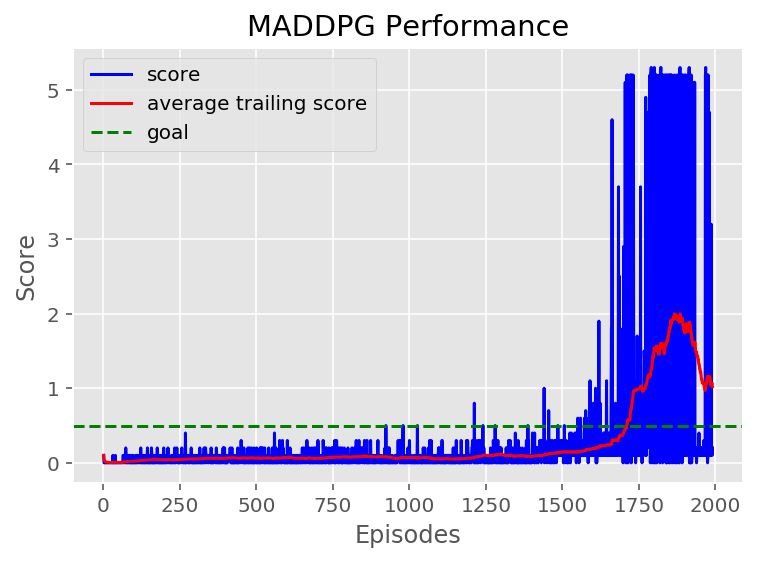

In [16]:
# Plot the scores and average scores during the training
plt.plot(np.arange(1, len(scores) + 1), scores, color = 'b', label = 'score')
plt.plot(np.arange(1, len(scores) + 1), avgs, color = 'r', label = 'average trailing score')
plt.axhline(0.5, linestyle = '--', color = 'g', label = 'goal')
plt.legend()
plt.title('MADDPG Performance')
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.savefig('maddpg_performance_20191108.png')

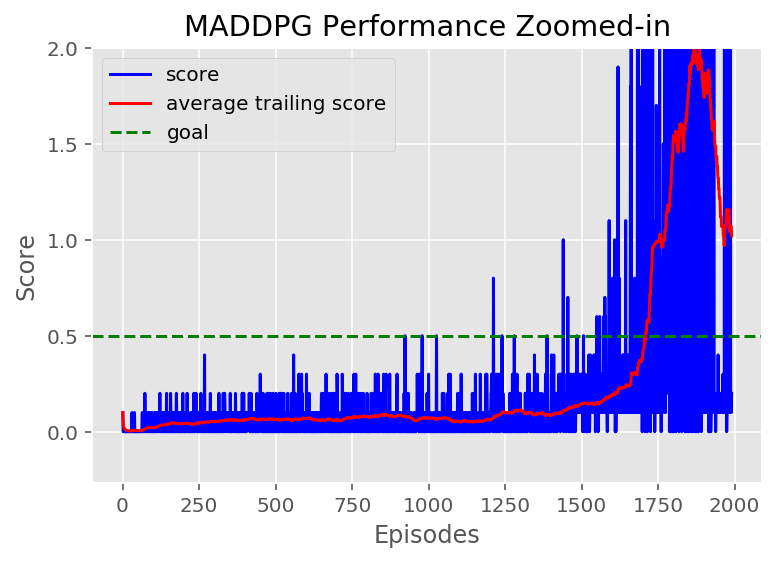

In [19]:
# Plot the scores and average scores during the training
plt.plot(np.arange(1, len(scores) + 1), scores, color = 'b', label = 'score')
plt.plot(np.arange(1, len(scores) + 1), avgs, color = 'r', label = 'average trailing score')
plt.axhline(0.5, linestyle = '--', color = 'g', label = 'goal')
plt.ylim(top = 2)
plt.legend()
plt.title('MADDPG Performance Zoomed-in')
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.savefig('maddpg_performance_20191108_z.png')

In [18]:
env.close()

### Stop here for my main implementation

### Secondary Implementation!!

I've encountered another implementation, which takes less time and achieve higher scores. I'm curious as to what the setups are, so I've included here for reference.

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import namedtuple, deque
import copy
import random
import numpy as np

from unityagents import UnityEnvironment


import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
env = UnityEnvironment(file_name='/data/Tennis_Linux_NoVis/Tennis')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
env_info = env.reset(train_mode=True)[brain_name]

In [5]:
class Config:
    def __init__(self):
        self.device = 'cpu'
        self.seed = 0
        self.network_fn = None
        self.optimizer_fn = None
        self.noise_fn = None
        self.hidden_units = None
        self.num_agents = 1
          
        self.shared_replay_buffer = False
        self.memory_fn = None
        self.memory = None
        
        self.actor_hidden_units = (64, 64)
        self.actor_network_fn = None
        self.actor_optimizer_fn = None
        self.actor_learning_rate = 1e-4 # vs. 1e-3

        self.critic_hidden_units = (64, 64)
        self.critic_network_fn = None
        self.critic_optimizer_fn = None
        self.critic_learning_rate = 3e-4 # vs. 1e-3
        
        self.tau = 1e-3 # vs. 8e-3 
        self.weight_decay = 0
        self.states = None
        self.state_size = None
        self.action_size = None
        self.learning_rate = 0.001
        self.gate = None
        self.batch_size = 256 # vs. 128 
        self.buffer_size = int(1e5) # vs. int(1e6)
        self.discount = 0.999 # vs. 0.99
        self.update_every = 16 # vs. 5
        self.gradient_clip = None
        self.entropy_weight = 0.01
        self.eps_start = 1.0 # vs. 5
        self.eps_end = 0.01 # vs. 300
        self.eps_decay = 0.995 # vs. 

In [6]:
config = Config()

config.seed = 2
config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config.action_size = brain.vector_action_space_size
config.states = env_info.vector_observations
config.state_size = config.states.shape[1]
config.num_agents = len(env_info.agents)

config.actor_hidden_units = (512,256)
config.actor_learning_rate = 1e-4
config.actor_network_fn = lambda: Actor(config.action_size, config.state_size, config.actor_hidden_units, config.seed).to(config.device)
config.actor_optimizer_fn = lambda params: torch.optim.Adam(params, lr=config.actor_learning_rate)

config.critic_hidden_units = (512,256)
config.critic_learning_rate = 3e-4
config.weight_decay = 0
config.critic_network_fn = lambda: Critic(config.action_size, config.state_size, config.critic_hidden_units, config.seed).to(config.device)
config.critic_optimizer_fn = lambda params: torch.optim.Adam(params, lr=config.critic_learning_rate)

config.shared_replay_buffer = True
config.batch_size = 512
config.buffer_size = int(1e6)
config.discount = 0.99
config.update_every = 4
config.memory_fn = lambda: ReplayBuffer(config.action_size, config.buffer_size, config.batch_size, config.seed, config.device)

config.noise_fn = lambda: OUNoise(config.action_size, config.seed)

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, action_size, state_size, hidden_units, seed, gate=F.relu, final_gate=F.tanh):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            hidden_units (array): Number of nodes for layers
            seed (int): Random seed
            gate (function): activation function
            final_gate (function): final activation function
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.gate = gate
        self.final_gate = final_gate
        self.normalizer = nn.BatchNorm1d(state_size)
        dims = (state_size, ) + hidden_units
        self.layers = nn.ModuleList([nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.output = nn.Linear(dims[-1], action_size)
        self.reset_parameters()

    def reset_parameters(self):        
        for layer in self.layers:
            layer.weight.data.uniform_(*hidden_init(layer))
        self.output.weight.data.uniform_(-3e-3, 3e-3)


    def forward(self, states):
        """Build an actor (policy) network that maps states -> actions."""
        x = self.normalizer(states)
        for layer in self.layers:
            x = self.gate(layer(x))
        return self.final_gate(self.output(x))

    
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, action_size, state_size, hidden_units, seed, gate=F.relu, dropout=0.2):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            hidden_units (array): Number of nodes for layers
            seed (int): Random seed
            gate (function): activation function
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.gate = gate
        self.dropout = nn.Dropout(p=dropout)
        self.normalizer = nn.BatchNorm1d(state_size)
        dims = (state_size, ) + hidden_units
        self.layers = nn.ModuleList()
        count = 0
        for dim_in, dim_out in zip(dims[:-1], dims[1:]):
            if count == 1:
                self.layers.append(nn.Linear(dim_in+action_size, dim_out))
            else:
                self.layers.append(nn.Linear(dim_in, dim_out))
            count += 1
        self.output = nn.Linear(dims[-1], 1)
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            layer.weight.data.uniform_(*hidden_init(layer))
        self.output.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, states, actions):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = self.normalizer(states)
        xs = self.gate(self.layers[0](xs))
        x = torch.cat((xs, actions), dim=1)
        for i in range(1, len(self.layers)):
            x = self.gate(self.layers[i](x))
        x = self.dropout(x)
        return self.output(x)

In [8]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [10]:
class DDPGAgent:
    def __init__(self, config):
        self.config = config
        self.seed = config.seed
        
        # Actor Network (w/ Target Network)
        self.actor_local = config.actor_network_fn()
        self.actor_target = config.actor_network_fn()
        self.actor_optimizer = config.actor_optimizer_fn(self.actor_local.parameters())
        
        # Critic Network (w/ Target Network)
        self.critic_local = config.critic_network_fn()
        self.critic_target = config.critic_network_fn()
        self.critic_optimizer = config.critic_optimizer_fn(self.critic_local.parameters())
        
        # ----------------------- initialize target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, 1)
        self.soft_update(self.actor_local, self.actor_target, 1)

        self.noise = config.noise_fn()
        
        if config.shared_replay_buffer:
            self.memory = config.memory
        else:
            self.memory = config.memory_fn()
        
    def reset(self):
        self.noise.reset()
        
    def act(self, states):            
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(self.config.device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        actions += self.noise.sample()
        return np.clip(actions, -1, 1)
                
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """

        states, actions, rewards, next_states, dones = experiences
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
#         torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.config.tau)
        self.soft_update(self.actor_local, self.actor_target, self.config.tau)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            

In [11]:
class DDPGAgent:
    def __init__(self, config):
        self.config = config
        self.seed = config.seed
        
        # Actor Network (w/ Target Network)
        self.actor_local = config.actor_network_fn()
        self.actor_target = config.actor_network_fn()
        self.actor_optimizer = config.actor_optimizer_fn(self.actor_local.parameters())
        
        # Critic Network (w/ Target Network)
        self.critic_local = config.critic_network_fn()
        self.critic_target = config.critic_network_fn()
        self.critic_optimizer = config.critic_optimizer_fn(self.critic_local.parameters())
        
        # ----------------------- initialize target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, 1)
        self.soft_update(self.actor_local, self.actor_target, 1)

        self.noise = config.noise_fn()
        
        if config.shared_replay_buffer:
            self.memory = config.memory
        else:
            self.memory = config.memory_fn()
        
    def reset(self):
        self.noise.reset()
        
    def act(self, states):            
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(self.config.device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        actions += self.noise.sample()
        return np.clip(actions, -1, 1)
                
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """

        states, actions, rewards, next_states, dones = experiences
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
#         torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.config.tau)
        self.soft_update(self.actor_local, self.actor_target, self.config.tau)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            

In [12]:
class MultiAgent:
    def __init__(self, config):
        self.config = config
        
        if config.shared_replay_buffer:
            self.memory = config.memory_fn()
            self.config.memory = self.memory
        
        self.ddpg_agents = [DDPGAgent(self.config) for _ in range(config.num_agents)]
        
        self.t_step = 0
     
    def reset(self):
        for agent in self.ddpg_agents:
            agent.reset()
    
    def act(self, all_states):
        """get actions from all agents in the MADDPG object"""
        actions = [agent.act(np.expand_dims(states, axis=0)) for agent, states in zip(self.ddpg_agents, all_states)]
        return actions
    
    def step(self, states, actions, rewards, next_states, dones):
        # Save experience in replay memory
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.config.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.config.batch_size:
                for agent in self.ddpg_agents:
                    if self.config.shared_replay_buffer:
                        experiences = self.memory.sample()
                    else:
                        experiences = agent.memory.sample()
                    
                    agent.learn(experiences, self.config.discount)

In [13]:
ma = MultiAgent(config)

In [15]:
def maddpg(n_episodes = 30000, max_t = 2000):
    all_scores = []
    scores_window = deque(maxlen=100)
    
    solved = False
    solved_ep = 0
    
    for i_episode in range(1, n_episodes+1):
        
        ma.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations           
        scores = np.zeros(config.num_agents)

        for i in range(max_t):
            actions = ma.act(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done

            ma.step(states, actions, rewards, next_states, dones)

            scores += rewards
            states = next_states
                
        avg_score = np.mean(scores)
        scores_window.append(avg_score)
        all_scores.append(avg_score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 10 == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 0.5 and solved == False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-5, np.mean(scores_window)))
            torch.save(ma.ddpg_agents[0].actor_local.state_dict(), 'ref_checkpoint_actor.pth')
            torch.save(ma.ddpg_agents[0].critic_local.state_dict(), 'ref_checkpoint_critic.pth')
            solved_ep = i_episode
            solved = True
        elif solved == True and i_episode > solved_ep + 15:
            break 
            
    return all_scores

In [16]:
scores = maddpg()

Episode 10	Average Score: -0.65Episode 10	Average Score: -0.65
Episode 20	Average Score: -0.43Episode 20	Average Score: -0.43
Episode 30	Average Score: -0.51Episode 30	Average Score: -0.51
Episode 40	Average Score: -0.40Episode 40	Average Score: -0.40
Episode 50	Average Score: 0.14Episode 50	Average Score: 0.14
Episode 58	Average Score: 0.53
Environment solved in 53 episodes!	Average Score: 0.53
Episode 60	Average Score: 0.63Episode 60	Average Score: 0.63
Episode 70	Average Score: 1.07Episode 70	Average Score: 1.07
Episode 74	Average Score: 1.21

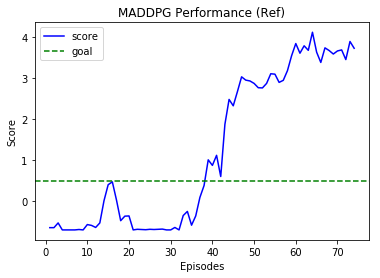

In [18]:
# Plot the scores and average scores during the training
plt.plot(np.arange(1, len(scores) + 1), scores, color = 'b', label = 'score')
plt.axhline(0.5, linestyle = '--', color = 'g', label = 'goal')
plt.legend()
plt.title('MADDPG Performance (Ref)')
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.savefig('ref_maddpg_performance_20191110.png')